***
# <center> Flower Images Classification using CNN</center>
#### <center> Student. Benhari Abdessalam </center>
#### <center> Mines Paristech - March 2021 </center>
#### <center> Project notebook </center>
***
## Introduction :
The aim of this project is to try to build a flower classification model that can classify flower images into 102 categories, the data used to train the models is _the 102-flowers dataset_ (This <a href=http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html>DATASET</a> was created by the Visual Geometry Group of Oxford University, and contains at least 40 examples for each of 102 types of flowers). The 102 categories (and numbers of examples for each) is described <a href=http://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html> HERE</a>.

To accomplish this task, we'll try at first to import our data, do some preprocessing to it, and then build and train our models (we'll use a simple model at first as a reference, then we'll apply some _<b>transfer learning</b>_ by re-using some well known model's layers).

Let's start by uploading our data :

## 1.Data importation :

In [1]:
# Libraries importation
import numpy as np 
import scipy.io
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf
import pathlib

import shutil
import os
from functools import partial

from tensorflow import keras

In [2]:
# Labels importation :
img_labels_mat = scipy.io.loadmat('data/imagelabels.mat')
img_labels = img_labels_mat.get('labels')
targets = img_labels[0]

NOTE : The next block is used once to restructure the data into a file tree, each of its branch is a flower class. this restructuration will help us on the data importation (since somehow the keras <code>image_dataset_from_directory</code> doesn't work correctly when given classes as a list (an existent bug)). 

In [ ]:
# Data reorganisation //DO NOT RUN MORE THAN ONCE.
noRun = True # to prevent it from running while executing the whole notebook
if noRun :
    None
else:
    for i in range(len(targets)):
        newpath = r"data/jpg/"+ str(targets[i]) 
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        shutil.copy("data/jpg/image_"+format(i+1, '05d')+
            ".jpg", "data/jpg/"+ str(targets[i])+ "/image_"+
            format(i+1, '05d')+".jpg")

In [28]:
# Data importation & splitting :
## used parameters
batch_size = 32 # default
dataset_size = len(targets)
image_size = (256,256) # default
val_size = int(0.6 *0.25*len(targets)/32)

## Train DataSet
train_data = tf.keras.preprocessing.image_dataset_from_directory(
                pathlib.Path('data/jpg/'), labels='inferred', label_mode='int',
                color_mode='rgb', batch_size=batch_size, image_size=image_size,
                shuffle=True, seed=123, validation_split=0.25, subset='training',
                interpolation='bilinear'
            )
## Class names & number
class_names = train_data.class_names
num_classes = 102

## Validation DataSet
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
                pathlib.Path('data/jpg/'), labels='inferred', label_mode='int',
                color_mode='rgb', batch_size=batch_size, image_size=image_size,
                shuffle=True, seed=123, validation_split=0.25, subset='validation',
                interpolation='bilinear'
            )
val_data = valid_data.take(val_size)

## Test Dataset 
test_data = valid_data.skip(val_size)

Found 8189 files belonging to 102 classes.
Using 6142 files for training.
Found 8189 files belonging to 102 classes.
Using 2047 files for validation.


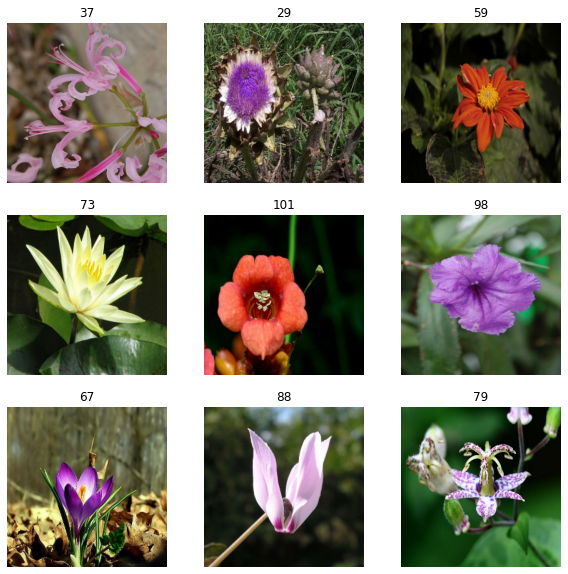

In [4]:
# Plotting the first pictures on the first batch (A simple verification)
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        i+=1
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 2.Basic model implementation :
### i.Model structure :
- First we use a preprocessing layer to rescale our images to a $[0, 1]$ shape.
- Next we use three convolutional layers, each followed by a MaxPooling layer to downsample our inputs and then get the most important features from each previous layer. 
- Next is the fully connected network, composed of one hidden dense layer and a
dense output layer. We did use a flatten array since the dense layers expect a 1D array. And since it is a classification problem, we use the softmax activation function on the last layer.

In [10]:
# Fist model (A Basic CNN):
## Model structure :
basic_model = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1./255),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation="softmax")
])

### ii.Compilation & fitting parameters :

For the model compilation, we use the <b>ADAM</b> optimiser to avoid the 'exploding gradient'/'The vanishing gradient' problems, and a <b>sparse cateorical crossentropy loss</b> since we are dealing with a multi-classification problem, and finally an accuracy metric to evaluate our model's performance throughout the learning-validation process :

In [11]:
## Model compilation :
basic_model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

To Regularise more our model, and avoid any possible overfitting, we'll use the <b>early-stopping</b> method : 

In [12]:
## Early stopping CallBack : 
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
    restore_best_weights=True)

## Fitting the data :
basic_model.fit(train_data,
    validation_data=val_data,
    callbacks=[early_stopping_cb],
    epochs=20)

Epoch 1/20
192/192 [==============================] - 255s 1s/step - loss: 4.3336 - accuracy: 0.0637 - val_loss: 3.4960 - val_accuracy: 0.1622
Epoch 2/20
192/192 [==============================] - 261s 1s/step - loss: 3.1735 - accuracy: 0.2278 - val_loss: 2.9003 - val_accuracy: 0.2868
Epoch 3/20
192/192 [==============================] - 264s 1s/step - loss: 2.2696 - accuracy: 0.4214 - val_loss: 2.7345 - val_accuracy: 0.3405
Epoch 4/20
192/192 [==============================] - 259s 1s/step - loss: 1.2862 - accuracy: 0.6575 - val_loss: 3.2717 - val_accuracy: 0.3444
Epoch 5/20
192/192 [==============================] - 259s 1s/step - loss: 0.5202 - accuracy: 0.8527 - val_loss: 4.3745 - val_accuracy: 0.3205
Epoch 6/20
192/192 [==============================] - 257s 1s/step - loss: 0.2134 - accuracy: 0.9349 - val_loss: 4.6108 - val_accuracy: 0.3327


### iii.Model evaluation & conclusion :
Obviously our model didn't perform well due to :
- its simplicity : not deep enough to capture all the data features 
- the lack of data to be able to augment the number of filters and then capture more features.

And even by overcoming the two reasons before, another reason may occure, which is related to the RAM and the learning time, the convolutional layers require a huge amount of RAM during training, because the reverse pass of backpropagation
requires all the intermediate values computed during the forward pass. Due to that, the learning time will be huge (if we want to build a decent (deep enough) model to capture all the data features).

Gladly, we can use some already pretrained layers from other models that treat almost the same task (image classification) by applying a transfer learning, the next models will use this method to try to minimise the learing time, exploit already built and trained (and famous) model layers, and maybe reach a much higher performance by using only the small amoount of data we have : 

## 3. Transfer learning & hybrid models :
In this part we'll use some already existent models to build our classification model, and do a benchmark at the end to choose the best suited model based on a performance comparison.

The methodology that we'll follow for each model is the following :
- First, we run the data through a data augmentation (that also plays a regulation role) & preprocessing pipeline (customised for each base model, since each one requires a special input shape)
- Next we create a custom model by using all the base model's layers except the output layer, and by adding our own output layers.
- Next we freeze our base model's layers and train the model on a small number of epochs (to help the new layers catch up, and also to not ruin the pretrained base layers)
- Finally we unfreeze some of the frozen layers, train our model (by using the early stopping method to avoid overfitting) and evaluate the model on the test data.

In [32]:
# Custom Data preprocessing (Different for each model):
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100

    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, model, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)

    resized_image = tf.image.resize(cropped_image, [224, 224])
    if model =="ResNet":
        final_image = keras.applications.resnet.preprocess_input(resized_image)
    elif model == "Xception":
        final_image = keras.applications.xception.preprocess_input(resized_image)
    elif model == "Inception":
        final_image = keras.applications.inception_v3.preprocess_input(resized_image)

    return final_image, label


### i.ResNet :

In [34]:
## Preprocessed data
train_data_rn = train_data.unbatch().map(partial(preprocess, model="ResNet", randomize=True)).batch(batch_size).prefetch(1)
val_data_rn = val_data.unbatch().map(partial(preprocess, model="ResNet")).batch(batch_size).prefetch(1)
test_data_rn = test_data.unbatch().map(partial(preprocess, model="ResNet")).batch(batch_size).prefetch(1)

In [43]:
# Prepare the base model :
base_model_rn = keras.applications.ResNet50(weights="imagenet",
                                                  include_top=False)

# Replacement layers
avg = keras.layers.GlobalAveragePooling2D()(base_model_rn.output)
output = keras.layers.Dense(num_classes, activation="softmax")(avg)

# Build our custom model :
model_rn = keras.models.Model(inputs=base_model_rn.input, outputs=output)

In [44]:
# Freezing the base model layers :
for layer in base_model_rn.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2,momentum=0.9, decay=0.01)
model_rn.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_rn.fit(train_data_rn.repeat(5),
                    steps_per_epoch=int(0.74 * dataset_size / batch_size),
                    validation_data=val_data_rn.repeat(5),
                    validation_steps=int(0.14 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
189/189 [==============================] - 446s 2s/step - loss: 32.6654 - accuracy: 0.4161 - val_loss: 3.7704 - val_accuracy: 0.8107
Epoch 2/5
189/189 [==============================] - 485s 3s/step - loss: 1.7605 - accuracy: 0.8937 - val_loss: 2.0609 - val_accuracy: 0.8625
Epoch 3/5
189/189 [==============================] - 499s 3s/step - loss: 0.7040 - accuracy: 0.9419 - val_loss: 1.3950 - val_accuracy: 0.8982
Epoch 4/5
189/189 [==============================] - 483s 3s/step - loss: 0.4032 - accuracy: 0.9637 - val_loss: 1.0700 - val_accuracy: 0.9196
Epoch 5/5
189/189 [==============================] - 455s 2s/step - loss: 0.2316 - accuracy: 0.9754 - val_loss: 1.2040 - val_accuracy: 0.9125


In [45]:
# Unfreezing the last base model layers :
num_layers = len(base_model_rn.layers)
for layer in base_model_rn.layers[num_layers-6:]:
    layer.trainable = True

# Nesterov GD optimiser (practical on deep CNN models to avoid GD problems)
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
## Early stopping CallBack : 
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
    restore_best_weights=True)

## Model compilation :
model_rn.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

## Model training :
history = model_rn.fit(train_data_rn.repeat(40),
                    steps_per_epoch=int(0.74 * dataset_size / batch_size),
                    validation_data=val_data_rn.repeat(40),
                    validation_steps=int(0.14 * dataset_size / batch_size),
                    callbacks=[early_stopping_cb],
                    epochs=5) 


Epoch 1/5
189/189 [==============================] - 482s 3s/step - loss: 0.3944 - accuracy: 0.9649 - val_loss: 1.4555 - val_accuracy: 0.8938
Epoch 2/5
189/189 [==============================] - 475s 3s/step - loss: 0.1492 - accuracy: 0.9811 - val_loss: 1.0484 - val_accuracy: 0.9062
Epoch 3/5
189/189 [==============================] - 488s 3s/step - loss: 0.0415 - accuracy: 0.9913 - val_loss: 0.9216 - val_accuracy: 0.9187
Epoch 4/5
189/189 [==============================] - 482s 3s/step - loss: 0.0272 - accuracy: 0.9953 - val_loss: 0.8690 - val_accuracy: 0.9187
Epoch 5/5
189/189 [==============================] - 478s 3s/step - loss: 0.0195 - accuracy: 0.9963 - val_loss: 0.8793 - val_accuracy: 0.9196


In [46]:
# Model evaluation :
model_rn.evaluate(test_data_rn)

26/26 [==============================] - 62s 2s/step - loss: 0.8171 - accuracy: 0.9134


[0.8171313405036926, 0.9133573770523071]

### ii.Xception :

In [47]:
## Preprocessed data
train_data_xcp = train_data.unbatch().map(partial(preprocess, model="Xception",randomize=True)).batch(batch_size).prefetch(1)
val_data_xcp = val_data.unbatch().map(partial(preprocess, model="Xception")).batch(batch_size).prefetch(1)
test_data_xcp = test_data.unbatch().map(partial(preprocess, model="Xception")).batch(batch_size).prefetch(1)

In [48]:
# Prepare the base model :
base_model_xcp = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)

# Replacement layers
avg = keras.layers.GlobalAveragePooling2D()(base_model_xcp.output)
output = keras.layers.Dense(num_classes, activation="softmax")(avg)

# Build our custom model :
model_xcp = keras.models.Model(inputs=base_model_xcp.input, outputs=output)

In [49]:
# Freezing the base model layers :
for layer in base_model_xcp.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2,momentum=0.9, decay=0.01)
model_xcp.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_xcp.fit(train_data_xcp.repeat(5),
                    steps_per_epoch=int(0.74 * dataset_size / batch_size),
                    validation_data=val_data_xcp.repeat(5),
                    validation_steps=int(0.14 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
189/189 [==============================] - 517s 3s/step - loss: 3.3424 - accuracy: 0.4045 - val_loss: 0.8478 - val_accuracy: 0.7759
Epoch 2/5
189/189 [==============================] - 532s 3s/step - loss: 0.5232 - accuracy: 0.8564 - val_loss: 0.5851 - val_accuracy: 0.8330
Epoch 3/5
189/189 [==============================] - 536s 3s/step - loss: 0.2791 - accuracy: 0.9233 - val_loss: 0.5485 - val_accuracy: 0.8446
Epoch 4/5
189/189 [==============================] - 524s 3s/step - loss: 0.2320 - accuracy: 0.9411 - val_loss: 0.5083 - val_accuracy: 0.8518
Epoch 5/5
189/189 [==============================] - 524s 3s/step - loss: 0.2110 - accuracy: 0.9498 - val_loss: 0.4904 - val_accuracy: 0.8580


In [50]:
# Unfreezing the last base model layers :
num_layers = len(base_model_xcp.layers)
for layer in base_model_xcp.layers[num_layers-6:]:
    layer.trainable = True

# Nesterov GD optimiser (practical on deep CNN models to avoid GD problems)
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
## Early stopping CallBack : 
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
    restore_best_weights=True)

## Model compilation :
model_xcp.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

## Model training :
history = model_xcp.fit(train_data_xcp.repeat(40),
                    steps_per_epoch=int(0.74 * dataset_size / batch_size),
                    validation_data=val_data_xcp.repeat(40),
                    validation_steps=int(0.14 * dataset_size / batch_size),
                    callbacks=[early_stopping_cb],
                    epochs=4)

Epoch 1/4
189/189 [==============================] - 585s 3s/step - loss: 0.3644 - accuracy: 0.9202 - val_loss: 0.3864 - val_accuracy: 0.8982
Epoch 2/4
189/189 [==============================] - 588s 3s/step - loss: 0.1304 - accuracy: 0.9731 - val_loss: 0.3147 - val_accuracy: 0.9161
Epoch 3/4
189/189 [==============================] - 594s 3s/step - loss: 0.0840 - accuracy: 0.9844 - val_loss: 0.3032 - val_accuracy: 0.9232
Epoch 4/4
189/189 [==============================] - 596s 3s/step - loss: 0.0690 - accuracy: 0.9902 - val_loss: 0.2673 - val_accuracy: 0.9196


In [51]:
# Model evaluation :
model_xcp.evaluate(test_data_xcp)

26/26 [==============================] - 84s 2s/step - loss: 0.2917 - accuracy: 0.9230


[0.29166290163993835, 0.9229843616485596]

By the result given by our models evaluation, the model build from Xception performed slightly better that the ResNet one, and way better than our first basic model with an accuracy over <b>92%</b>!. so for any future predictions, that one would be model of choice.

Notes : 

- We could improve our model's accuracy by unfreezing more layers (and then going deeper on the network) but that would take so much time, and since we're pretty satisfied with our results, we're going to stop here. 
- We could fine tune our models by tweaking its parameters on the layers we added, but since those arent a lot, and we didn t witness any abnormal behavior or a drop in performance, we skipped this part to save up some time.